In [8]:
import sys
!{sys.executable} -m pip install neo4j


  Using cached neo4j-5.28.2-py3-none-any.whl.metadata (5.9 kB)
Using cached neo4j-5.28.2-py3-none-any.whl (313 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip3.12 install --upgrade pip


# Connect to Neo4j from Python — what this cell does (and why)

This notebook uses the **official Neo4j Python Driver** to connect to your database over the **Bolt** protocol, run parameterized Cypher, and return results as pandas DataFrames. The Python driver exposes the same core concepts as other Neo4j drivers (Driver → Session → Transaction) and is the recommended way to build apps or notebooks against Neo4j.

---

## Connection basics

- **URI & routing.** `neo4j://` enables the driver’s **routing** behavior (works for single servers and clusters). If you explicitly want a direct one-to-one connection, use `bolt://` (or `bolt+s` / `bolt+ssc` for TLS variants). Keep `neo4j://` unless you have a reason to force direct connections. :contentReference[oaicite:1]{index=1}  
- **Auth.** Supply `("user","password")`; the driver handles connection pooling for you. 
- **Bolt.** Queries are sent via Bolt (binary) for low-latency query execution. 

---

## Sessions, transactions, and this notebook’s pattern

Neo4j is **ACID**. Work happens inside transactions so reads/writes are atomic and consistent. 

There are two common ways to run queries from Python:

1) **Managed transactions** with retries: `session.execute_read(...)` / `session.execute_write(...)`. The driver wraps your callback in a transaction and automatically retries on retryable errors (best for robust apps).

2) **Auto-commit** queries: `session.run(...)` (what this notebook uses in `query(...)`). This is faster and simpler for notebooks; each call runs in its own auto-commit transaction. It won’t auto-retry on transient failures (you trade some robustness for throughput/simplicity).

---

## Parameters (use them!)

Cypher **parameters** keep your queries safe and fast:
- Avoid string building / injection risks.
- Enable **plan caching** so repeated queries run faster.
- In Cypher, parameters are referenced as `$name` and supplied from the driver as a dict/kwargs (e.g., `s.run("MATCH (n {name:$x}) RETURN n", x="Alice")`). 

---

## What each function/variable below does

- **CONFIG (URI, USER, PASS, DEFAULTS).** Central place to adjust connection info and default values for common parameters (group, technique, etc.).

- **`driver = GraphDatabase.driver(...)`**  
  Creates a **Driver** with a connection pool. Keep one per process and reuse it; close it when done.

- **`close()`**  
  Closes the driver/pool cleanly (good practice in notebooks when you’re finished).

- **`df_from_result(result)`**  
  Converts the driver’s `Result` (an iterator of records) into a list of dicts and then a pandas **DataFrame**—handy for tabular display.

- **`query(q: str, **params)`**  
  Opens a short-lived **Session**, runs Cypher with **parameters**, and returns a DataFrame. This uses **auto-commit** under the hood (`session.run`), which is ideal for interactive exploration. For production code that needs automatic retries, prefer `session.execute_read/write`.

---

## Usage tips

- Reuse the **Driver**, not Sessions. Create short Sessions inside helper functions (as shown) to avoid keeping transactions open.
- Always pass **parameters** (`$param`) instead of formatting values into the Cypher string. It’s safer and lets the planner cache execution plans.
- If you later add long-running writes or multi-step logic, switch to **managed transactions** (`execute_write/execute_read`) to get automatic retry semantics. 
- The same code works with **Neo4j Desktop**, **Docker/Podman**, **Aura**, and clusters. Just change `NEO4J_URI`, `NEO4J_USER`, `NEO4J_PASS`.

---

## Quick reference

- **Python driver manual (connect, sessions, transactions):**  
  https://neo4j.com/docs/python-manual/current/  
  *Official guide to creating a Driver, opening Sessions, and running queries.* 

- **Managed transactions (`execute_read` / `execute_write`):**  
  https://neo4j.com/docs/python-manual/current/performance/  
  *Shows transaction functions that auto-retry on transient failures.* 

- **Auto-commit queries (`session.run`):**  
  https://neo4j.com/docs/python-manual/current/transactions/  
  *Explains auto-commit vs explicit/managed transactions.* 

- **Cypher parameters (why & how):**  
  https://neo4j.com/docs/cypher-manual/current/syntax/parameters/  
  *Parameters improve safety and enable plan caching; use `$name` in Cypher.* 

- **Routing vs direct URIs (`neo4j://` vs `bolt://`):**  
  https://neo4j.com/docs/bolt/current/driver-api/#uri-schemes  
  *`neo4j://` enables routing (good defaults, cluster-ready); `bolt://` is direct.* 

- **Bolt protocol overview:**  
  https://neo4j.com/docs/bolt/current/  
  *Binary protocol used by the drivers for low-latency query execution.* 


In [6]:
from neo4j import GraphDatabase
import pandas as pd
from typing import Dict, Any, List

# ---------- CONFIG ----------
NEO4J_URI  = "neo4j://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PASS = "YourStrongPass123!"

DEFAULTS = {
    "group": "APT29",
    "tech": "Credential Dumping",
    "tactic": "defense-evasion",
    "g1": "APT29",
    "g2": "FIN7",
    "software": "Mimikatz",
    "recent_days": 180,
}

# ---------- UTILS ----------

driver = GraphDatabase.driver("neo4j://localhost:7687", auth=("neo4j","YourStrongPass123!"))

def close():
    driver.close()

def df_from_result(result) -> pd.DataFrame:
    rows = [dict(r) for r in result]
    return pd.DataFrame(rows)


def query(q: str, **params) -> pd.DataFrame:
    with driver.session() as s:
        res = s.run(q, **params)
        return df_from_result(res)

def _print_section(title: str, df: pd.DataFrame):
    print(f"\\n=== {title} ===")
    if df is None:
        print("(no results)")
        return
    if df.empty:
        print("(empty)")
    else:
        # limit very wide cells for tebrminal readability
        with pd.option_context("display.max_colwidth", 80, "display.width", 140):
            print(df.to_string(index=False))


# MITRE ATT&CK (STIX 2.1) — Knowledge Base → Neo4j Knowledge Graph

This section documents **what the dataset is**, **how we turn it into a property graph**, and **why it matters** for security analytics and attack-surface reasoning.

---

## 1) What is this dataset?

**MITRE ATT&CK** is an open, curated knowledge base of **adversary behavior**. It captures:
- **Who**: adversary *groups* (intrusion-sets) and *campaigns*
- **How**: *techniques* and *sub-techniques* adversaries use
- **With what**: *tools* and *malware*
- **How to defend**: *mitigations* (courses of action), *data sources* and *data components* for detection

MITRE publishes ATT&CK as **STIX 2.1 JSON** collections. The official repo you cloned contains three top-level bundles (https://github.com/mitre-attack/attack-stix-data):

- enterprise-attack/enterprise-attack.json
- mobile-attack/mobile-attack.json
- ics-attack/ics-attack.json



Each bundle is a **graph** of typed objects + explicit relationship objects.

---

## 2) What’s inside (interesting details)

### Object types you’ll see most often
- `attack-pattern` → **techniques** and **sub-techniques**
- `x-mitre-tactic` → **tactics** (the columns in the ATT&CK matrix)
- `intrusion-set` → **groups** (APT, FIN*, etc.)
- `tool`, `malware` → **software** used by groups
- `course-of-action` → **mitigations**
- `x-mitre-data-source`, `x-mitre-data-component` → **detection** concepts
- plus `campaign`, `relationship`, and other STIX objects

### Key relationship semantics (from STIX `relationship` objects)
- `uses` — group→technique, group→software, software→technique
- `mitigates` — course-of-action→technique
- `detects` — data-source/data-component→technique
- `subtechnique-of` — technique hierarchy
- many others (e.g., `compromises`, `targets`, etc., depending on object types)

### Rich metadata you can query
- `x_mitre_platforms` (Windows, Linux, macOS, Azure, AWS, GCP, SaaS, Network…)
- `kill_chain_phases` (e.g., `defense-evasion`, `credential-access`), which link techniques to tactics
- `revoked` / `x_mitre_deprecated` flags (for currency)
- `created` / `modified` timestamps (for recency)
- Domains (enterprise, mobile, ics)

> **Why this is nice for graphs:** ATT&CK is already a **linked** knowledge base with typed nodes and edges. That makes it perfect for a property-graph like Neo4j, where you can ask “Who uses what, which tactic is affected, and how do we mitigate/detect it?” with a few hops.

---

## 3) Our Neo4j graph model (Labeled Property Graph)

We import the STIX bundles into a streamlined **property graph**:

**Nodes**
- Label: `:Attack`
- Properties (subset):  
  `id, stix_type, name, description, created, modified, revoked, deprecated, platforms[], domains[], kc_phases[], shortname`

**Relationships**
- Type: `:ATTACK_REL` (1:1 with STIX *relationship* objects)  
  Properties: `id, rel_type, description`  
  Examples: `rel_type = 'uses' | 'mitigates' | 'detects' | 'subtechnique-of' | …`

**Helper edges**
- `(:Attack {stix_type:'attack-pattern'})-[:IN_TACTIC]->(:Attack {stix_type:'x-mitre-tactic'})`  
  Derived from `kill_chain_phases` to make tactic queries fast and readable.

This keeps the graph faithful to STIX while giving you intuitive patterns to query.

---

## 4) How we create the knowledge graph (repeatable steps)

> You can run this from the Neo4j Browser or the Python driver. It assumes your JSON file is in Neo4j’s `/import` (e.g., `file:///enterprise-attack/enterprise-attack.json`) and APOC is enabled.

**(a) Constraint (idempotent)**
```cypher
CREATE CONSTRAINT attack_id IF NOT EXISTS
FOR (n:Attack) REQUIRE n.id IS UNIQUE;


## Part A - Orientation

#### How big is the graph?

In [11]:
def A1_counts():
    q1 = "MATCH (n:Attack) RETURN count(n) AS nodes"
    q2 = "MATCH ()-[r:ATTACK_REL]->() RETURN count(r) AS relationships"
    return query(q1), query(q2)

In [13]:
nodes_df, rels_df = A1_counts()

_print_section("A1 counts — nodes", nodes_df)
_print_section("A1 counts — relationships", rels_df)

\n=== A1 counts — nodes ===
 nodes
  2242
\n=== A1 counts — relationships ===
 relationships
         20411


## Visualizing a sample of the ATT&CK knowledge graph

Below we:
1) Pick a **seed** node (e.g., a group like “APT29”)  
2) Fetch its **k-hop neighborhood** (both `ATTACK_REL` and `IN_TACTIC` edges)  
3) Visualize as:
   - **Static** graph with NetworkX + Matplotlib (quick and reliable)
   - **Interactive** HTML using PyVis (hover tooltips; pan/zoom)

> Tip: keep `depth` small (e.g., 1–2) and set a `limit` to avoid huge plots.


In [24]:
# --- requirements: networkx / matplotlib (and optionally pyvis) ---
# %pip install networkx matplotlib pyvis  # uncomment if needed

import networkx as nx
import matplotlib.pyplot as plt
from typing import Optional, Tuple

def find_seed(name_substr: str, stix_type: str | None = None):
    """
    Find a seed node by case-insensitive substring on :Attack.name,
    optionally restricted to a given stix_type (e.g., 'intrusion-set').
    Returns (id, name) or None if not found.
    """
    if stix_type:
        qtxt = """
        MATCH (n:Attack {stix_type:$t})
        WHERE toLower(n.name) CONTAINS toLower($term)
        RETURN n.id AS id, n.name AS name
        LIMIT 1
        """
        df = query(qtxt, t=stix_type, term=name_substr)
    else:
        qtxt = """
        MATCH (n:Attack)
        WHERE toLower(n.name) CONTAINS toLower($term)
        RETURN n.id AS id, n.name AS name, n.stix_type AS stix_type
        LIMIT 1
        """
        df = query(qtxt, term=name_substr)

    if df.empty:
        return None
    row = df.iloc[0]
    return (row["id"], row["name"])


def fetch_subgraph(seed_id: str, depth: int = 2, limit: int = 300, include_in_tactic: bool = True):
    """
    Fetch a de-duplicated node+edge sample around a given node id.
    Includes both ATTACK_REL and (optionally) IN_TACTIC edges.
    Returns (nodes_df, edges_df).
    """
    rel_pattern = "ATTACK_REL|IN_TACTIC" if include_in_tactic else "ATTACK_REL"
    depth_int = int(depth)  # must be literal inside the pattern

    q_nodes = f"""
    MATCH p = (n:Attack {{id:$id}})-[:{rel_pattern}*1..{depth_int}]-(m:Attack)
    UNWIND nodes(p) AS x
    WITH DISTINCT x
    RETURN x.id AS id, x.name AS name, x.stix_type AS stix_type
    LIMIT $limit
    """

    q_edges = f"""
    MATCH p = (n:Attack {{id:$id}})-[:{rel_pattern}*1..{depth_int}]-(m:Attack)
    UNWIND relationships(p) AS r
    WITH DISTINCT r
    RETURN startNode(r).id AS source, endNode(r).id AS target,
           type(r) AS type, r.rel_type AS rel_type
    LIMIT $limit
    """

    nodes_df = query(q_nodes, id=seed_id, limit=limit)
    ids = set(nodes_df["id"].tolist())
    edges_df = query(q_edges, id=seed_id, limit=limit)
    if not edges_df.empty:
        edges_df = edges_df[edges_df["source"].isin(ids) & edges_df["target"].isin(ids)].copy()

    return nodes_df, edges_df


def plot_networkx(nodes_df: pd.DataFrame, edges_df: pd.DataFrame, seed_id: Optional[str] = None, title: str = ""):
    """
    Static visualization using NetworkX + Matplotlib.
    Colors by stix_type, labels by name (truncated). Highlights the seed node.
    """
    if nodes_df.empty:
        print("No nodes to plot."); return
    G = nx.DiGraph()
    # add nodes with attributes
    for _, r in nodes_df.iterrows():
        G.add_node(r["id"], name=r.get("name", r["id"]), kind=r.get("stix_type","?"))

    # add edges
    if not edges_df.empty:
        for _, r in edges_df.iterrows():
            label = r.get("rel_type") or r.get("type")
            G.add_edge(r["source"], r["target"], label=label)

    # color palette by common ATT&CK types
    palette = {
        "attack-pattern": "#1f77b4",
        "x-mitre-tactic": "#ff7f0e",
        "intrusion-set":  "#2ca02c",
        "malware":        "#d62728",
        "tool":           "#9467bd",
        "course-of-action":"#8c564b",
        "x-mitre-data-component":"#e377c2",
        "x-mitre-data-source":"#7f7f7f",
    }

    node_colors = []
    node_sizes  = []
    labels      = {}
    for n, data in G.nodes(data=True):
        kind = (data.get("kind") or "").lower()
        node_colors.append(palette.get(kind, "#17becf"))
        size = 700 if n == seed_id else 400
        node_sizes.append(size)
        # trim long names for readability
        name = data.get("name", n)
        labels[n] = name if len(name) <= 24 else (name[:21] + "…")

    pos = nx.spring_layout(G, k=0.6, seed=42)
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors="#333")
    nx.draw_networkx_edges(G, pos, arrows=True, width=1.2, alpha=0.6)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

    # draw a small edge label sample (at most 15 to avoid clutter)
    if edges_df is not None and not edges_df.empty:
        sample = edges_df.head(15)
        edge_label_dict = {(row.source, row.target): (row.rel_type or row.type) for _, row in sample.iterrows()}
        nx.draw_networkx_edge_labels(G, pos, edge_label_dict, font_size=8, label_pos=0.5)

    plt.title(title or "ATT&CK Knowledge Graph — Sample")
    plt.axis("off")
    plt.show()

def show_pyvis(nodes_df: pd.DataFrame, edges_df: pd.DataFrame, seed_id: Optional[str] = None, output_html="kg_sample.html"):
    """
    Interactive visualization using PyVis.
    Opens/embeds an HTML network with hover tooltips and pan/zoom.
    """
    try:
        from pyvis.network import Network
    except ImportError:
        print("PyVis not installed. Run:  %pip install pyvis")
        return

    net = Network(height="800px", width="100%", directed=True, notebook=True, bgcolor="#ffffff")
    net.barnes_hut()

    # group by stix_type for legend/colors
    for _, r in nodes_df.iterrows():
        nid = r["id"]; name = r.get("name", nid); kind = r.get("stix_type","?")
        title = f"<b>{name}</b><br/>{kind}"
        color = None
        if str(kind).lower() == "intrusion-set": color = "#2ca02c"
        elif str(kind).lower() == "attack-pattern": color = "#1f77b4"
        elif str(kind).lower() == "x-mitre-tactic": color = "#ff7f0e"
        elif str(kind).lower() == "malware": color = "#d62728"
        elif str(kind).lower() == "tool": color = "#9467bd"
        elif str(kind).lower() == "course-of-action": color = "#8c564b"
        net.add_node(nid, label=name, title=title, group=str(kind), color=color,
                     size=25 if nid == seed_id else 16)

    if not edges_df.empty:
        for _, r in edges_df.iterrows():
            label = r.get("rel_type") or r.get("type")
            net.add_edge(r["source"], r["target"], label=label, arrows="to", physics=True)

    net.show(output_html)
    print(f"Saved interactive graph to {output_html} (open in browser).")



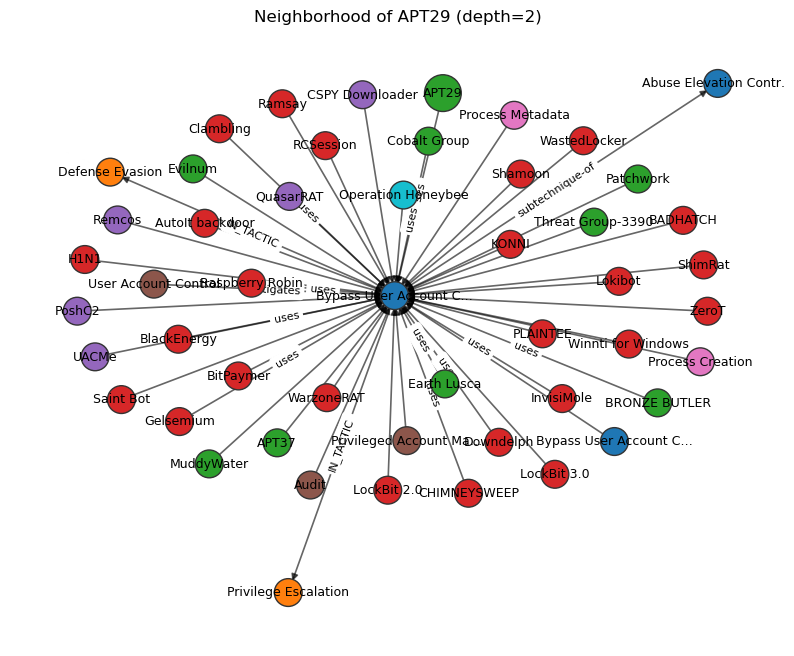

attack_kg_sample.html
Saved interactive graph to attack_kg_sample.html (open in browser).


In [30]:
# 1) Pick a seed (group) and fetch its 2-hop neighborhood
seed = find_seed("APT29", stix_type="intrusion-set")
if not seed:
    raise RuntimeError("Seed not found. Try another name, e.g., 'FIN7' or a technique keyword.")
seed_id, seed_name = seed

nodes_s, edges_s = fetch_subgraph(seed_id, depth=2, limit=50, include_in_tactic=True)

# 2a) Static plot
plot_networkx(nodes_s, edges_s, seed_id=seed_id, title=f"Neighborhood of {seed_name} (depth=2)")

# 2b) Interactive HTML (optional)
show_pyvis(nodes_s, edges_s, seed_id=seed_id, output_html="attack_kg_sample.html")


## What you’re seeing: “Neighborhood of APT29 (depth=2)”

This picture is a **2-hop neighborhood** of the node we searched for, **APT29** (an ATT&CK *intrusion set*).  
We asked Neo4j for all nodes reachable from APT29 by following either:

- `ATTACK_REL` edges (e.g., `uses`, `mitigates`, `subtechnique-of`, …), and
- `IN_TACTIC` edges (the helper edge we created from `kill_chain_phases`).

We limited the result to a few hundred nodes/edges and laid it out with a spring layout.

### How to read it

- **Colors = STIX types**  
  - **Green** → `intrusion-set` (threat groups like APT29, FIN7, Cobalt Group)  
  - **Blue** → `attack-pattern` (techniques/sub-techniques, e.g., *Bypass User Account Control*)  
  - **Orange** → `x-mitre-tactic` (tactics such as *defense-evasion*)  
  - **Red** → `malware`  
  - **Purple** → `tool`  
  - **Brown** → `course-of-action` (mitigation)  
  - **Pink** → `x-mitre-data-component`  
  - **Gray** → `x-mitre-data-source`

- **Edge labels**  
  - Most gray labels say **`uses`** (e.g., *APT29 —uses→ QuasarRAT* or *APT29 —uses→ Bypass UAC*).  
  - **`subtechnique-of`** connects sub-techniques to parent techniques.  
  - **`IN_TACTIC`** connects techniques to the tactics they belong to.

- **Node sizes**  
  The seed you searched for (APT29) is drawn slightly larger. A large “hub” in the center can also be a highly connected **technique** (blue) such as *Bypass User Account Control*—the layout naturally pulls hubs to the middle.

### Why there are many nodes that aren’t APT29

Because we asked for **two hops** (`depth=2`) with undirected traversal:

- **1 hop** from APT29 gets you APT29’s direct neighbors: techniques it uses, tools/malware it uses, and the tactics of those techniques.  
- **2 hops** then brings in *other* groups, tools, or techniques that share those neighbors.  
  Example: *APT29 —uses→ Bypass UAC ←uses— LockBit* brings **LockBit** into view even though it’s a different group/campaign.

This is useful for seeing **shared tradecraft** (who else uses the same techniques or software) and for spotting **popular tactics/techniques** (central blue/orange hubs).

### What insights can you call out in this view

- **Common techniques**: Central blue nodes (e.g., *Bypass UAC*) indicate frequently used techniques across multiple groups—high-value for defense prioritization.  
- **Group → software → technique chains**: You’ll see red/purple nodes attached to APT29; follow their edges to see which **techniques** those tools enable.  
- **Tactic coverage**: Orange nodes show which tactics APT29’s techniques fall under (e.g., *defense-evasion*, *credential-access*).  
- **Shared ecosystem**: Other green nodes (groups) appearing within two hops share techniques or software with APT29.



## What is a Knowledge Graph?

A **knowledge graph** = a graph whose nodes/edges are **typed** and **semantically meaningful** (based on a domain schema/ontology), curated so you can ask **who/what/why/how** questions.

The **MITRE ATT&CK** graph fits that perfectly: entities like **groups, techniques, tools, mitigations, tactics** and relationships like **uses, mitigates, detects, subtechnique-of**. It encodes **domain knowledge**, not just raw events.

---

## What are h, r, t?

They’re the classic triple components:

- **h (head)** = the starting entity (**subject**)
- **r (relation)** = the relationship/verb (**predicate**)
- **t (tail)** = the ending entity (**object**)

**In ATT&CK terms:**
- `(h,r,t) = ("APT29", "uses", "Bypass User Account Control")`
- `(h,r,t) = ("Bypass User Account Control", "IN_TACTIC", "defense-evasion")`
- `(h,r,t) = ("Mimikatz", "uses", "Credential Dumping")`
- `(h,r,t) = ("Application Control", "mitigates", "Bypass User Account Control")`

---

## How that maps to Neo4j (property graph)

- **h → node**
  ```cypher
  (:Attack {name:"APT29", stix_type:"intrusion-set"})
- **r → relationship**
  ```cypher
  ([:ATTACK_REL {rel_type:"uses"}]    // or
    [:IN_TACTIC])
- **t → nodee**
  ```cypher
    (:Attack {name:"Bypass User Account Control", stix_type:"attack-pattern"})



#### A2. What kinds of objects do we have? (techniques, malware, groups…)

In [46]:
def A2_object_types():
    q = """
    MATCH (n:Attack)
    RETURN n.stix_type AS type, count(*) AS n
    ORDER BY n DESC
    """
    return query(q)

In [48]:
_print_section("A2 object types", A2_object_types())


\n=== A2 object types ===
                  type   n
        attack-pattern 823
               malware 667
      course-of-action 268
         intrusion-set 181
x-mitre-data-component 109
                  tool  91
              campaign  47
   x-mitre-data-source  38
        x-mitre-tactic  14
    x-mitre-collection   1
        x-mitre-matrix   1
              identity   1
    marking-definition   1


#### A3. What relationship types are most common?

In [53]:
def A3_relationship_types():
    q = """
    MATCH ()-[r:ATTACK_REL]->()
    RETURN r.rel_type AS rel_type, count(*) AS n
    ORDER BY n DESC
    """
    return query(q)

_print_section("A3 relationship types", A3_relationship_types())


\n=== A3 relationship types ===
       rel_type     n
           uses 16241
        detects  2116
      mitigates  1421
subtechnique-of   470
     revoked-by   140
  attributed-to    23


#### A4. Which tactics have the most techniques?

In [57]:
def A4_tactic_technique_counts():
    q = """
    MATCH (tac:Attack {stix_type:'x-mitre-tactic'})<-[:IN_TACTIC]-(tech:Attack {stix_type:'attack-pattern'})
    RETURN tac.shortname AS tactic, count(tech) AS techniques
    ORDER BY techniques DESC
    """
    return query(q)

_print_section("A4 tactic -> technique counts", A4_tactic_technique_counts())


\n=== A4 tactic -> technique counts ===
              tactic  techniques
     defense-evasion         258
         persistence         180
privilege-escalation         139
   credential-access          80
           execution          67
 command-and-control          55
           discovery          48
resource-development          47
      reconnaissance          44
          collection          40
              impact          38
    lateral-movement          34
      initial-access          25
        exfiltration          21


#### A5. Active vs deprecated/revoked techniques

In [62]:
def A5_active_vs_inactive():
    q = """
    MATCH (t:Attack {stix_type:'attack-pattern'})
    RETURN
      sum(CASE WHEN coalesce(t.deprecated,false) OR coalesce(t.revoked,false) THEN 1 ELSE 0 END) AS inactive,
      sum(CASE WHEN NOT coalesce(t.deprecated,false) AND NOT coalesce(t.revoked,false) THEN 1 ELSE 0 END) AS active
    """
    return query(q)

_print_section("A5 techniques active vs inactive", A5_active_vs_inactive())


\n=== A5 techniques active vs inactive ===
 inactive  active
      144     679


## Part B — Threat-intel pivots (Who does what?)

#### B1. Techniques used by a specific group

In [65]:
def B1_group_techniques(group=DEFAULTS["group"]):
    q = """
    WITH toLower($group) AS g
    MATCH (grp:Attack {stix_type:'intrusion-set'})
    WHERE toLower(grp.name) CONTAINS g
    MATCH (grp)-[:ATTACK_REL {rel_type:'uses'}]->(tech:Attack {stix_type:'attack-pattern'})
    OPTIONAL MATCH (tech)-[:IN_TACTIC]->(tac:Attack {stix_type:'x-mitre-tactic'})
    RETURN tac.shortname AS tactic, tech.name AS technique
    ORDER BY tactic, technique
    LIMIT 150
    """
    return query(q, group=group)

_print_section("B1 techniques used by group", B1_group_techniques(DEFAULTS["group"]))


\n=== B1 techniques used by group ===
              tactic                                             technique
          collection                                Data from Local System
          collection                               Remote Email Collection
 command-and-control                                       Domain Fronting
 command-and-control                                    Dynamic Resolution
 command-and-control                                     Encrypted Channel
 command-and-control                                        External Proxy
 command-and-control                                   Hide Infrastructure
 command-and-control                                 Ingress Tool Transfer
 command-and-control                                       Multi-hop Proxy
   credential-access                                       Hybrid Identity
   credential-access                                           LSA Secrets
   credential-access        Multi-Factor Authentication Reques

#### B2. Software a group uses (tools & malware)

In [70]:
def B2_group_software(group=DEFAULTS["group"]):
    q = """
    WITH toLower($group) AS g
    MATCH (grp:Attack {stix_type:'intrusion-set'})
    WHERE toLower(grp.name) CONTAINS g
    MATCH (grp)-[:ATTACK_REL {rel_type:'uses'}]->(s:Attack)
    WHERE s.stix_type IN ['tool','malware']
    RETURN s.stix_type AS kind, s.name AS software
    ORDER BY kind, software
    LIMIT 100
    """
    return query(q, group=group)

_print_section("B2 software used by group", B2_group_software(DEFAULTS["group"]))


\n=== B2 software used by group ===
   kind      software
malware       BoomBox
malware     CloudDuke
malware Cobalt Strike
malware    CosmicDuke
malware       CozyCar
malware     EnvyScout
malware       FatDuke
malware      FoggyWeb
malware    GeminiDuke
malware    GoldFinder
malware       GoldMax
malware    HAMMERTOSS
malware      LiteDuke
malware      MiniDuke
malware    NativeZone
malware     OnionDuke
malware       POSHSPY
malware     PinchDuke
malware  PolyglotDuke
malware     PowerDuke
malware     QUIETEXIT
malware      Raindrop
malware       RegDuke
malware      SUNBURST
malware       SUNSPOT
malware       SeaDuke
malware         Sibot
malware      SoreFang
malware      TEARDROP
malware   TrailBlazer
malware     VaporRage
malware      WellMail
malware      WellMess
malware       reGeorg
   tool  AADInternals
   tool        AdFind
   tool    BloodHound
   tool      Impacket
   tool      Mimikatz
   tool           Net
   tool        PsExec
   tool     ROADTools
   tool       SDel

#### B3. Techniques used via software (2-hop)

In [76]:
def B3_group_techniques_via_software(group=DEFAULTS["group"]):
    q = """
    WITH toLower($group) AS g
    MATCH (grp:Attack {stix_type:'intrusion-set'})
    WHERE toLower(grp.name) CONTAINS g
    MATCH (grp)-[:ATTACK_REL {rel_type:'uses'}]->(s:Attack)
    WHERE s.stix_type IN ['tool','malware']
    MATCH (s)-[:ATTACK_REL {rel_type:'uses'}]->(tech:Attack {stix_type:'attack-pattern'})
    WITH s, collect(DISTINCT tech.name) AS techniques
    RETURN s.name AS software, techniques
    ORDER BY size(techniques) DESC
    LIMIT 20
    """
    return query(q, group=group)

_print_section("B3 techniques via software", B3_group_techniques_via_software(DEFAULTS["group"]))


\n=== B3 techniques via software ===
     software                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

#### B4. Which groups use a given technique?

In [79]:
def B4_technique_users(self, tech=DEFAULTS["tech"]):
    q = """
    WITH toLower($tech) AS t
    MATCH (tech:Attack {stix_type:'attack-pattern'})
    WHERE toLower(tech.name) CONTAINS t
    MATCH (grp:Attack {stix_type:'intrusion-set'})-[:ATTACK_REL {rel_type:'uses'}]->(tech)
    RETURN tech.name AS technique, collect(DISTINCT grp.name) AS groups
    LIMIT 10
    """
    return query(q, tech=tech)

_print_section("B4 groups that use a technique", B4_technique_users(DEFAULTS["tech"]))


\n=== B4 groups that use a technique ===
            technique                                                                                                      groups
OS Credential Dumping [Suckfly, Ember Bear, APT28, APT39, APT32, Leviathan, BlackByte, Tonto Team, Axiom, Sowbug, Poseidon Group]


#### B5. Top groups by number of techniques

In [83]:
def B5_top_groups_by_techniques():
    q = """
    MATCH (g:Attack {stix_type:'intrusion-set'})-[:ATTACK_REL {rel_type:'uses'}]->(t:Attack {stix_type:'attack-pattern'})
    RETURN g.name AS group, count(DISTINCT t) AS techniques
    ORDER BY techniques DESC LIMIT 20
    """
    return query(q)

_print_section("B5 top groups by techniques", B5_top_groups_by_techniques())


\n=== B5 top groups by techniques ===
            group  techniques
          Kimsuky         103
    Lazarus Group          92
            APT28          91
            APT41          82
     Volt Typhoon          81
    Sandworm Team          79
      Magic Hound          79
            APT32          78
           OilRig          76
            Turla          68
            APT29          66
    Wizard Spider          64
          Chimera          59
       MuddyWater          58
Threat Group-3390          57
        Dragonfly          56
  Gamaredon Group          55
            APT38          55
          TeamTNT          54
             FIN7          53


#### B6. Shortest connection between two groups (via techniques/software)

In [88]:
def B6_shortest_connection_between_groups(g1=DEFAULTS["g1"], g2=DEFAULTS["g2"]):
    q = """
    MATCH (a:Attack {stix_type:'intrusion-set'}), (b:Attack {stix_type:'intrusion-set'})
    WHERE toLower(a.name) CONTAINS toLower($g1) AND toLower(b.name) CONTAINS toLower($g2)
    MATCH p = shortestPath((a)-[:ATTACK_REL*..6]-(b))
    RETURN p
    """
    return query(q, g1=g1, g2=g2)


_print_section("B6 shortest connection between groups", B6_shortest_connection_between_groups(DEFAULTS["g1"], DEFAULTS["g2"]))


\n=== B6 shortest connection between groups ===
                                                         p
((rel_type, description, id), (rel_type, description, id))


## Part C — Defense: mitigations & detections

##### C1. Mitigations for a group’s techniques

In [92]:
def C1_group_mitigations(group=DEFAULTS["group"]):
    q = """
    WITH toLower($group) AS g
    MATCH (grp:Attack {stix_type:'intrusion-set'}) WHERE toLower(grp.name) CONTAINS g
    MATCH (grp)-[:ATTACK_REL {rel_type:'uses'}]->(tech:Attack {stix_type:'attack-pattern'})
    MATCH (co:Attack {stix_type:'course-of-action'})<-[:ATTACK_REL {rel_type:'mitigates'}]-(tech)
    RETURN tech.name AS technique, collect(DISTINCT co.name) AS mitigations
    ORDER BY technique LIMIT 50
    """
    return query(q, group=group)

_print_section("C1 mitigations for group's techniques", C1_group_mitigations(DEFAULTS["group"]))


\n=== C1 mitigations for group's techniques ===
(empty)


#### C2. Coverage gaps: techniques used by the group with no mitigations

In [96]:
def C2_group_mitigation_gaps(group=DEFAULTS["group"]):
    q = """
    WITH toLower($group) AS g
    MATCH (grp:Attack {stix_type:'intrusion-set'}) WHERE toLower(grp.name) CONTAINS g
    MATCH (grp)-[:ATTACK_REL {rel_type:'uses'}]->(tech:Attack {stix_type:'attack-pattern'})
    OPTIONAL MATCH (co:Attack {stix_type:'course-of-action'})<-[:ATTACK_REL {rel_type:'mitigates'}]-(tech)
    WITH tech, count(co) AS c WHERE c = 0
    RETURN tech.name AS unmitigated ORDER BY unmitigated LIMIT 50
    """
    return query(q, group=group)

_print_section("C2 mitigation gaps", C2_group_mitigation_gaps(DEFAULTS["group"]))

\n=== C2 mitigation gaps ===
                                   unmitigated
                        Accessibility Features
         Additional Email Delegate Permissions
                                Binary Padding
          Boot or Logon Initialization Scripts
                   Bypass User Account Control
                                     Cloud API
                                 Cloud Account
                                 Cloud Account
                                Cloud Accounts
                                Cloud Accounts
                  Cloud Administration Command
                                Cloud Services
                        Data from Local System
                           Device Registration
                          Digital Certificates
                  Disable or Modify Cloud Logs
                               Domain Fronting
                            Dynamic Resolution
                                Email Accounts
                             En

#### C3. Detection coverage (if your dataset has data components)

In [98]:
def C3_detection_coverage_top(limit=25):
    q = """
    MATCH (tech:Attack {stix_type:'attack-pattern'})
    OPTIONAL MATCH (dc:Attack {stix_type:'x-mitre-data-component'})-[:ATTACK_REL {rel_type:'detects'}]->(tech)
    RETURN tech.name AS technique, count(dc) AS detectors
    ORDER BY detectors DESC
    LIMIT $limit
    """
    return query(q, limit=limit)

_print_section("C3 detection coverage (top techniques)", C3_detection_coverage_top(25))


\n=== C3 detection coverage (top techniques) ===
                          technique  detectors
                    Impair Defenses         19
Modify Cloud Compute Infrastructure         15
                  Indicator Removal         14
      Modify Authentication Process         13
                     Hide Artifacts         13
                       Masquerading         12
    Create or Modify System Process         11
                     User Execution         11
  Boot or Logon Autostart Execution         10
                    Windows Service         10
    Obfuscated Files or Information         10
              OS Credential Dumping         10
                   Data Destruction         10
        System Owner/User Discovery          9
                 Resource Hijacking          9
          Event Triggered Execution          9
                      Input Capture          9
                     Domain Account          8
  Abuse Elevation Control Mechanism          8
           

#### C4. Data components & sources that detect a named technique

In [103]:
def C4_detections_for_tech(tech=DEFAULTS["tech"]):
    q = """
    WITH toLower($tech) AS t
    MATCH (tech:Attack {stix_type:'attack-pattern'}) WHERE toLower(tech.name) CONTAINS t
    OPTIONAL MATCH (dc:Attack {stix_type:'x-mitre-data-component'})-[:ATTACK_REL {rel_type:'detects'}]->(tech)
    OPTIONAL MATCH (ds:Attack {stix_type:'x-mitre-data-source'})-[:ATTACK_REL {rel_type:'detects'}]->(tech)
    RETURN tech.name, collect(DISTINCT dc.name) AS data_components, collect(DISTINCT ds.name) AS data_sources
    """
    return query(q, tech=tech)

_print_section("C4 data components/sources for technique", C4_detections_for_tech(DEFAULTS["tech"]))


\n=== C4 data components/sources for technique ===
            tech.name                                                                                                                                                                                                 data_components data_sources
OS Credential Dumping [Network Traffic Content, Active Directory Object Access, Windows Registry Key Access, Process Creation, Process Access, File Access, Network Traffic Flow, Command Execution, File Creation, OS API Execution]           []


### Part D — Structure & taxonomy (tactics, subtechniques, platforms)

#### D1. Technique ↔ tactic mapping for a named tactic

In [108]:
def D1_tactic_mapping(tactic=DEFAULTS["tactic"]):
    q = """
    WITH toLower($tactic) AS tac
    MATCH (t:Attack {stix_type:'x-mitre-tactic'})
    WHERE toLower(t.shortname) = tac OR toLower(t.name) CONTAINS tac
    MATCH (tech:Attack {stix_type:'attack-pattern'})-[:IN_TACTIC]->(t)
    RETURN t.shortname AS tactic, collect(tech.name)[0..25] AS sample_techniques, count(tech) AS total
    """
    return query(q, tactic=tactic)

_print_section("D1 tactic mapping", D1_tactic_mapping(DEFAULTS["tactic"]))

\n=== D1 tactic mapping ===
         tactic                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    sample_techniques  total
defense-evasion [Extra Window Memory Injection, Socket Filters, Indicator Removal from Tools, Fileless Storage, Rundll32, Hidden Window, Embedded Payloads, Plist Modification, Pluggable Authentication Modules, Revert Cloud Instance, HISTCONTROL, File/Path Exclusions, Linux and Mac File and Directory Permissions Modification, PubPrn, Path Interception by PATH Environ

#### D2. Parent technique → subtechniques

In [111]:
def D2_subtechniques():
    q = """
    MATCH (sub:Attack {stix_type:'attack-pattern'})-[:ATTACK_REL {rel_type:'subtechnique-of'}]->(parent:Attack {stix_type:'attack-pattern'})
    RETURN parent.name AS technique, collect(sub.name) AS subtechniques
    ORDER BY size(subtechniques) DESC
    LIMIT 20
    """
    return query(q)

_print_section("D2 parent -> subtechniques", D2_subtechniques())


\n=== D2 parent -> subtechniques ===
                        technique                                                                                                                                                                                                                                                                                                                                                                                               subtechniques
  Obfuscated Files or Information                                                                 [Fileless Storage, Embedded Payloads, Encrypted/Encoded File, Stripped Payloads, Binary Padding, Junk Code Insertion, SVG Smuggling, LNK Icon Smuggling, Indicator Removal from Tools, Polymorphic Code, Steganography, Compile After Delivery, HTML Smuggling, Command Obfuscation, Software Packing, Dynamic API Resolution, Compression]
        Event Triggered Execution [PowerShell Profile, LC_LOAD_DYLIB Addition, Application Shimming, Tr

#### D3. Techniques by platform (Windows, Linux, Cloud, etc.)

In [115]:
def D3_techniques_by_platform():
    q = """
    UNWIND ['windows','linux','macos','azure','aws','gcp','saas','office 365','network'] AS platform
    MATCH (tech:Attack {stix_type:'attack-pattern'})
    WHERE platform IN [p IN coalesce(tech.platforms,[]) | toLower(p)]
    RETURN platform, count(tech) AS technique_count
    ORDER BY technique_count DESC
    """
    return query(q)

_print_section("D3 techniques by platform", D3_techniques_by_platform())


\n=== D3 techniques by platform ===
  platform  technique_count
   windows              568
     macos              423
     linux              400
      saas               68
office 365                3


### D4. Domain breakdown (enterprise / mobile / ics)

In [118]:
def D4_domain_breakdown():
    q = """
    UNWIND ['enterprise-attack','mobile-attack','ics-attack'] AS dom
    MATCH (n:Attack)
    WHERE dom IN [d IN coalesce(n.domains,[]) | toLower(d)]
    RETURN dom AS domain, count(n) AS nodes
    ORDER BY nodes DESC
    """
    return query(q)

_print_section("D4 domain breakdown", D4_domain_breakdown())


\n=== D4 domain breakdown ===
           domain  nodes
enterprise-attack   2239
       ics-attack     79
    mobile-attack     30


#### D5. What changed recently? (techniques modified in last 180 days)

In [121]:
def D5_recently_modified(recent_days=DEFAULTS["recent_days"]):
    q = """
    MATCH (t:Attack {stix_type:'attack-pattern'})
    WHERE t.modified >= datetime() - duration({days:$days})
    RETURN t.name AS technique, t.modified
    ORDER BY t.modified DESC
    LIMIT 25
    """
    return query(q, days=recent_days)

_print_section("D5 recently modified techniques", D5_recently_modified(DEFAULTS["recent_days"]))


\n=== D5 recently modified techniques ===
                                            technique                          t.modified
                               Remote Access Hardware 2025-05-02T19:13:42.314000000+00:00
                             Malicious Copy and Paste 2025-04-30T17:53:48.667000000+00:00
                                 Windows Admin Shares 2025-04-25T15:16:26.092000000+00:00
                                          InstallUtil 2025-04-25T15:16:24.168000000+00:00
                  Custom Command and Control Protocol 2025-04-25T15:16:23.937000000+00:00
                                           PowerShell 2025-04-25T15:16:22.903000000+00:00
                                    Service Execution 2025-04-25T15:16:22.595000000+00:00
                                 NTFS File Attributes 2025-04-25T15:16:22.196000000+00:00
                                    Fallback Channels 2025-04-25T15:16:21.879000000+00:00
                                Dynamic Data Exchange 2025

## Part E — “Put it all together” mini-scenarios
### E1. Build a mitigation backlog for a target group

- Run B1 to list techniques;

- Run C1 to collect mitigations;

- Run C2 to flag gaps → prioritize gaps first.

### E2. Choose detections for a critical tactic

- Use D1 to get all techniques in the tactic (e.g., defense-evasion), then C3/C4 to pick the most detectable ones for quick wins.

### E3. Software pivot

- Given a tool/malware name, list all groups that use it and the techniques it enables:

#### Please solve E1, and E2 by yourself.

In [128]:
def E3_software_pivot(software=DEFAULTS["software"]):
    q = """
    WITH toLower($software) AS q
    MATCH (s:Attack) WHERE s.stix_type IN ['tool','malware'] AND toLower(s.name) CONTAINS q
    OPTIONAL MATCH (g:Attack {stix_type:'intrusion-set'})-[:ATTACK_REL {rel_type:'uses'}]->(s)
    OPTIONAL MATCH (s)-[:ATTACK_REL {rel_type:'uses'}]->(tech:Attack {stix_type:'attack-pattern'})
    RETURN s.name AS software, collect(DISTINCT g.name) AS groups, collect(DISTINCT tech.name)[0..25] AS techniques
    """
    return query(q, software=software)

_print_section("E3 software pivot", E3_software_pivot(DEFAULTS["software"]))


\n=== E3 software pivot ===
software                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   groups                                                                                                                                                                                                                                                                                                                                                                          techniques
Mimikatz [APT38, menuPass, APT39, PittyTiger, Blue Mockingbird, Kimsuky, Volt Typhoon,